In [ ]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings('ignore')

In [ ]:
stock_data = pd.read_csv("../b Datasets/Mindtree Stock Price/Mindtree Stock Price.csv")
display(stock_data.head(2))
display(stock_data.tail(2))

,Date,Closing
0,04-12-2020,1411.6
1,07-12-2020,1414.3


,Date,Closing
257,30-11-2021,4547.35
258,01-12-2021,4591.05


In [3]:
date_feature = pd.date_range(start='12-04-2020', end='12-01-2021', freq='B') # B stands for business day.
len(date_feature)

259

In [4]:
stock_data.drop(labels='Date', axis=1, inplace=True)
stock_data['Date'] = date_feature
stock_data.set_index(keys='Date', inplace=True)
display(stock_data.head(2))
display(stock_data.tail(2))

,Closing
Date,
2020-12-04,1411.6
2020-12-07,1414.3


,Closing
Date,
2021-11-30,4547.35
2021-12-01,4591.05


In [5]:
stock_data.isna().sum()

Closing    0
dtype: int64

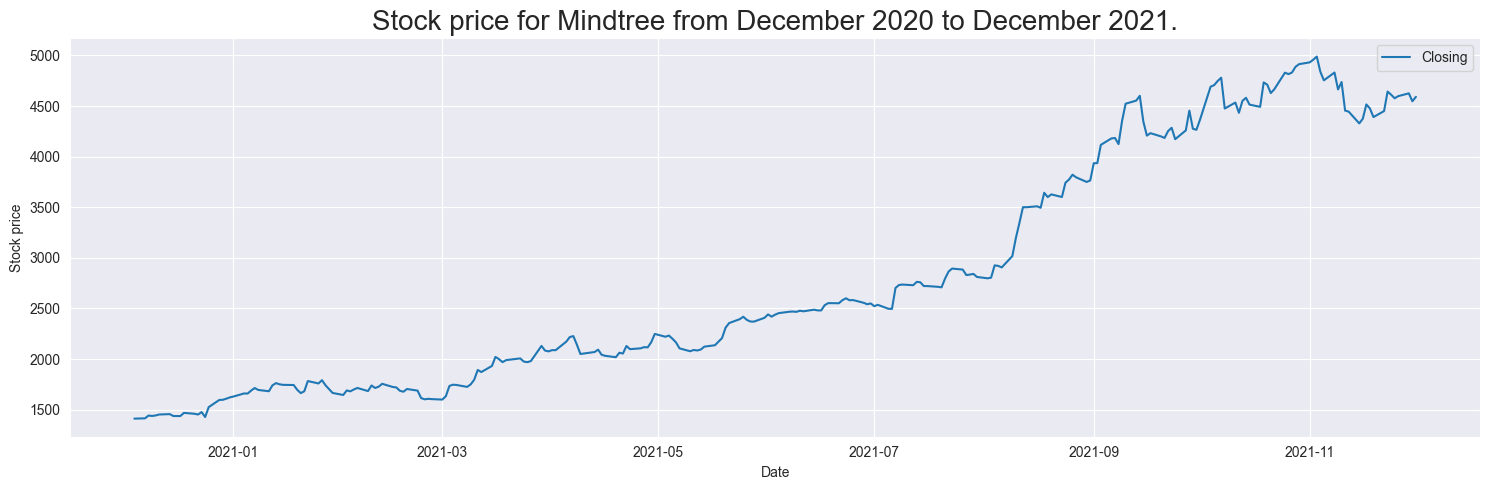

In [6]:
plt.figure(figsize=(15, 5))
sns.set_style('darkgrid')
sns.lineplot(data=stock_data)
plt.ylabel("Stock price")
plt.title("Stock price for Mindtree from December 2020 to December 2021.", fontsize=20)
plt.tight_layout()
plt.show()

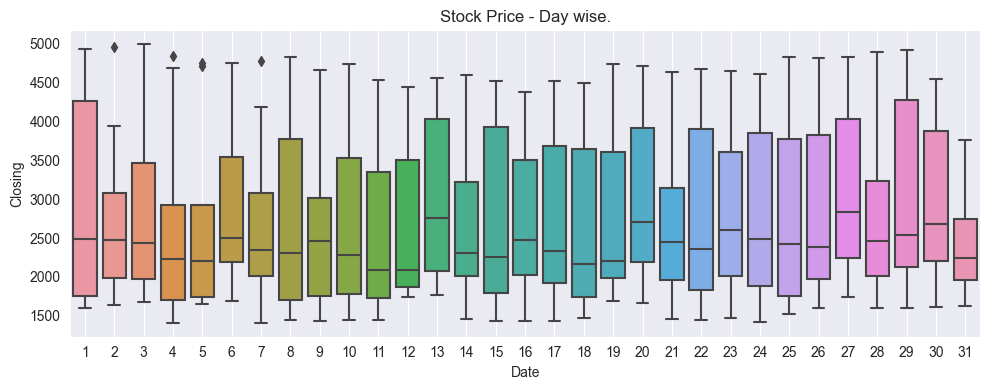

In [7]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=stock_data.index.day, y=stock_data['Closing'])
plt.title('Stock Price - Day wise.')
plt.grid()
plt.tight_layout()
plt.show()

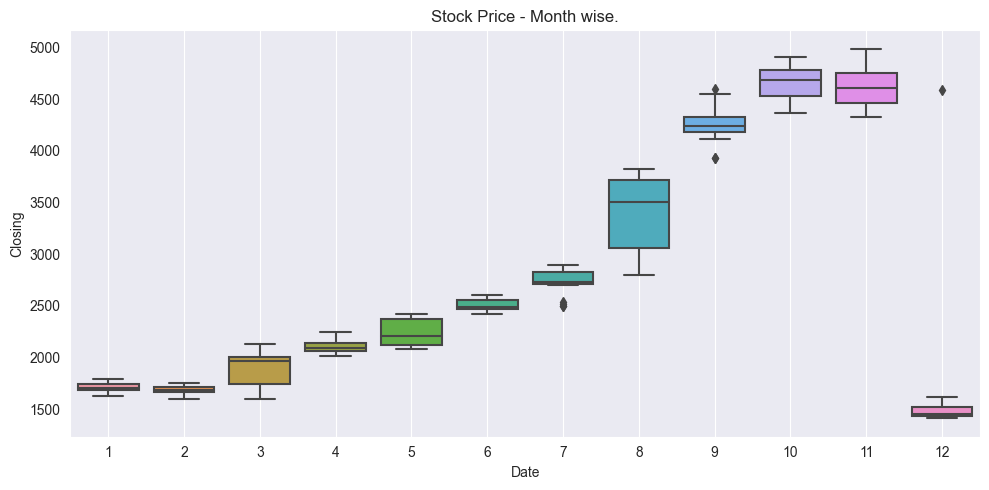

In [8]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=stock_data.index.month, y=stock_data['Closing'])
plt.title('Stock Price - Month wise.')
plt.grid()
plt.tight_layout()
plt.show()

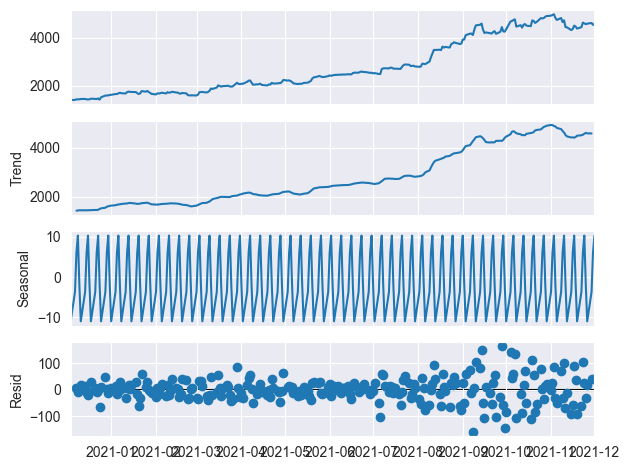

In [9]:
decomposition = seasonal_decompose(stock_data, model='additive')
decomposition.plot();

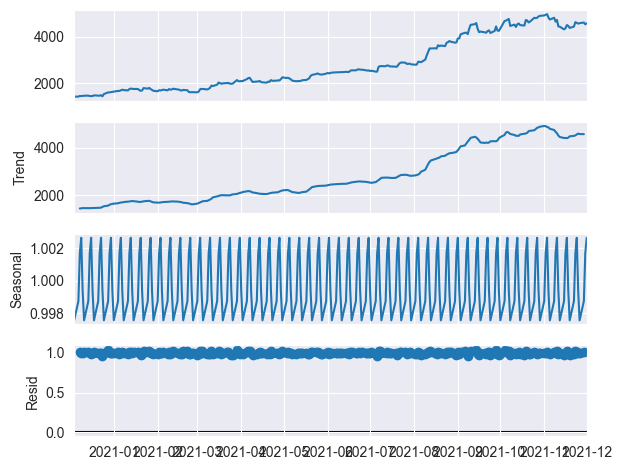

In [10]:
decomposition = seasonal_decompose(stock_data, model='multiplicative')
decomposition.plot();

In [11]:
adf, p_value, *_ = adfuller(stock_data.values)
print(f"ADF Test Statistic: {adf:.2f}")
print(f"P Value: {p_value:.2f}")

if p_value < 0.05:
    print("P value is less than 0.05. Data is stationary. No differencing required.")
else:
    print("P value is greater than 0.05. Data is NOT stationary. Differencing is required.")

ADF Test Statistic: -0.01
P Value: 0.96
P value is greater than 0.05. Data is NOT stationary. Differencing is required.


In [12]:
print("Applying first order differencing.")
stock_data_differenced = stock_data.diff(periods=1).dropna()
differenced_stock_prices = stock_data_differenced.values
adf, p_value, *_ = adfuller(differenced_stock_prices)
print(f"ADF Test Statistic: {adf:.2f}")
print(f"P Value: {p_value:.2f}")

if p_value < 0.05:
    print("P value is less than 0.05. Data is stationary. No differencing required.")
else:
    print("P value is greater than 0.05. Data is NOT stationary. Differencing is required.")

Applying first order differencing.
ADF Test Statistic: -15.39
P Value: 0.00
P value is less than 0.05. Data is stationary. No differencing required.


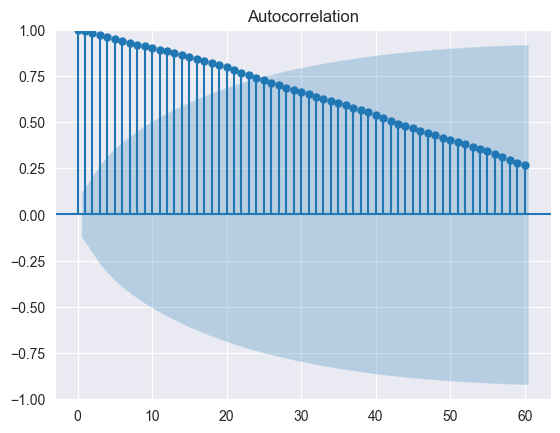

In [13]:
plot_acf(stock_data, lags=60);

With the slow rate of decay, it is evident that the data is stationary. It needs differencing.
Let us observer the differenced data.

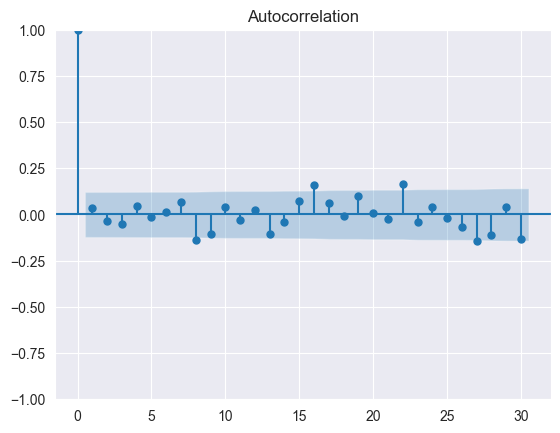

In [14]:
plot_acf(differenced_stock_prices, lags=30);

There is now an abrupt cut off after one initial spike. This signifies MA(q = 1)

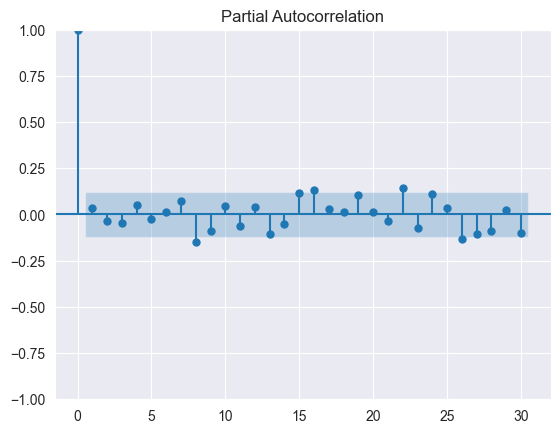

In [15]:
plot_pacf(differenced_stock_prices, lags=30);

This plot is showing one spikes before cut-off. This signifies that AR(p = 1)

In [16]:
train_end = datetime(2021, 9, 30)
train_data = stock_data[: train_end]
validation_data = stock_data[train_end + timedelta(days=1) :]

display(train_data.head(2))
display(train_data.tail(2))
display(validation_data.head(2))
display(validation_data.tail(2))
train_data.shape, validation_data.shape

,Closing
Date,
2020-12-04,1411.6
2020-12-07,1414.3


,Closing
Date,
2021-09-29,4275.6
2021-09-30,4265.4


,Closing
Date,
2021-10-01,4363.85
2021-10-04,4691.20


,Closing
Date,
2021-11-30,4547.35
2021-12-01,4591.05


((215, 1), (44, 1))

In [17]:
p = q = range(1, 3)  # p,q=0 is ignored since we saw that the cut off after 1 lag in acf and pacf plots.
d = range(1, 2)  # d=0 is ignored since the data is not stationary and differencing is needed.

pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [18]:
aic_df = pd.DataFrame(columns=['param','seasonal', 'AIC'])
aic_df

,param,seasonal,AIC


In [ ]:
for param in pdq:
    for param_seasonal in model_pdq:
            mod = SARIMAX(train_data,
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)

            results_SARIMA = mod.fit()
            detail = pd.DataFrame({'param': [param], 
                                   'seasonal': [param_seasonal], 
                                   'AIC': [results_SARIMA.aic]})
            aic_df = pd.concat([aic_df, detail], ignore_index=True)
    print(f"Iteration complete for param value: {param}")
print("AIC calculation for entire grid is complete.")

Iteration complete for param value: (1, 1, 1)
Iteration complete for param value: (1, 1, 2)
Iteration complete for param value: (2, 1, 1)
Iteration complete for param value: (2, 1, 2)
AIC calculation for entire grid is complete.


In [20]:
aic_df.sort_values(by='AIC', inplace=True)
aic_df

,param,seasonal,AIC
13,"(2, 1, 2)","(1, 1, 2, 12)",1947.052324
15,"(2, 1, 2)","(2, 1, 2, 12)",1951.859835
5,"(1, 1, 2)","(1, 1, 2, 12)",1953.283538
7,"(1, 1, 2)","(2, 1, 2, 12)",1955.174153
1,"(1, 1, 1)","(1, 1, 2, 12)",1963.798399
3,"(1, 1, 1)","(2, 1, 2, 12)",1965.591177
9,"(2, 1, 1)","(1, 1, 2, 12)",1966.998954
10,"(2, 1, 1)","(2, 1, 1, 12)",1967.379943
11,"(2, 1, 1)","(2, 1, 2, 12)",1968.858658
14,"(2, 1, 2)","(2, 1, 1, 12)",1969.352196


In [ ]:
sarimax_model = SARIMAX(train_data,
                        order=aic_df['param'].iloc[0],
                        seasonal_order=aic_df['seasonal'].iloc[0],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
sarimax_results = sarimax_model.fit()
sarimax_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Closing   No. Observations:                  215
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -965.526
Date:                            Sun, 24 Nov 2024   AIC                           1947.052
Time:                                    18:00:39   BIC                           1972.371
Sample:                                12-04-2020   HQIC                          1957.322
                                     - 09-30-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6970      0.074    -22.967      0.000      -1.842      -1.552
ar.L2         -0.7591      0.073    -10.463      0.000      -0.901      -0.617
ma.L1          1.9197      0.353      5.432      0.000       1.227       2.612
ma.L2          0.9972      0.365      2.731      0.006       0.281       1.713
ar.S.L12      -0.4999      0.470     -1.064      0.287      -1.421       0.421
ma.S.L12      -0.2017      0.459     -0.439      0.660      -1.102       0.698
ma.S.L24      -0.4463      0.329     -1.359      0.174      -1.090       0.198
sigma2      3670.9008   1363.976      2.691      0.007     997.557    6344.245
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):                79.35
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               3.80   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
sarimax_forecast = sarimax_results.forecast(steps=len(validation_data))

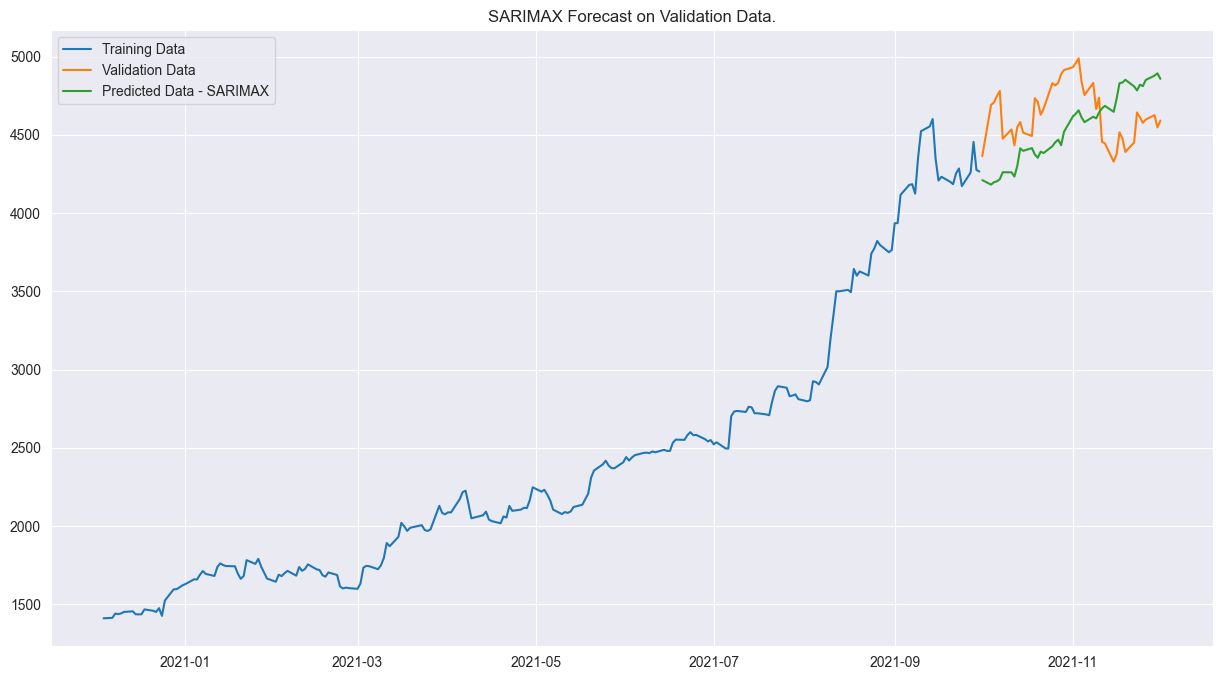

In [23]:
plt.figure(figsize=(15, 8))
plt.plot(train_data,label='Training Data')
plt.plot(validation_data,label='Validation Data')
plt.plot(validation_data.index, sarimax_forecast,label='Predicted Data - SARIMAX')
plt.legend(loc='best')
plt.title('SARIMAX Forecast on Validation Data.')
plt.minorticks_on()
plt.show()

In [24]:
validation_rmse = mean_squared_error(validation_data, sarimax_forecast, squared=False)
print(f"Validation RMSE: {validation_rmse}")

Validation RMSE: 316.1001431968249


In [25]:
validation_mape = mean_absolute_percentage_error(validation_data, sarimax_forecast) * 100
print(f"Validation MAPE: {validation_mape}")

Validation MAPE: 6.275387962170334


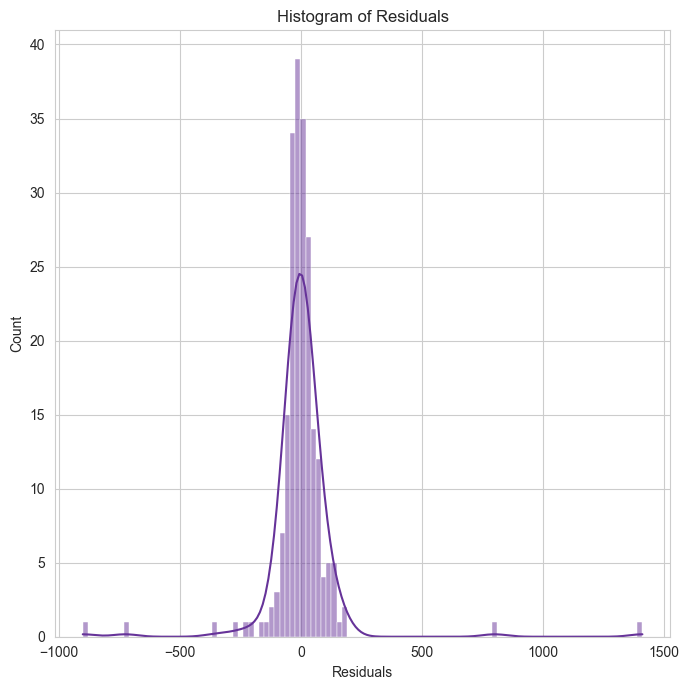

In [26]:
plt.figure(figsize=(7, 7))
sns.set_style('whitegrid')
sns.histplot(sarimax_results.resid.values, kde=True, color="rebeccapurple")
plt.xlabel("Residuals")
plt.title("Histogram of Residuals")
plt.tight_layout()
plt.show()

In [27]:
sarimax_results.resid.skew()

2.8712021684042335

In [ ]:
sarimax_model = SARIMAX(stock_data,
                        order=aic_df['param'].iloc[0],
                        seasonal_order=aic_df['seasonal'].iloc[0],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
sarimax_results = sarimax_model.fit()
sarimax_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Closing   No. Observations:                  259
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -1259.534
Date:                            Sun, 24 Nov 2024   AIC                           2535.068
Time:                                    18:00:42   BIC                           2562.180
Sample:                                12-04-2020   HQIC                          2546.018
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8310      0.105     -7.921      0.000      -1.037      -0.625
ar.L2         -0.8264      0.085     -9.671      0.000      -0.994      -0.659
ma.L1          0.9434      0.115      8.236      0.000       0.719       1.168
ma.L2          0.8418      0.109      7.737      0.000       0.629       1.055
ar.S.L12       0.0017      0.317      0.005      0.996      -0.619       0.623
ma.S.L12      -1.0141      0.303     -3.342      0.001      -1.609      -0.419
ma.S.L24       0.1839      0.277      0.663      0.508      -0.360       0.728
sigma2      5584.8992    344.072     16.232      0.000    4910.531    6259.268
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):               215.78
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               6.11   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
forecast_start_date = datetime(2021, 12, 1) + timedelta(days=1)
forecast_end_date = datetime(2022, 1, 1)
sarimax_forecast = sarimax_results.predict(start=forecast_start_date, end=forecast_end_date, freq='B')
sarimax_forecast

2021-12-02    4695.775260
2021-12-03    4750.204128
2021-12-06    4747.613772
2021-12-07    4780.998539
2021-12-08    4780.194726
2021-12-09    4786.448953
2021-12-10    4822.642312
2021-12-13    4794.146017
2021-12-14    4856.672572
2021-12-15    4783.332083
2021-12-16    4800.688488
2021-12-17    4749.577734
2021-12-20    4830.452526
2021-12-21    4909.970835
2021-12-22    4900.307161
2021-12-23    4903.083010
2021-12-24    4916.883007
2021-12-27    4953.764614
2021-12-28    4971.558102
2021-12-29    4941.925443
2021-12-30    4999.836024
2021-12-31    4930.443602
2022-01-03    4932.960507
Freq: B, Name: predicted_mean, dtype: float64

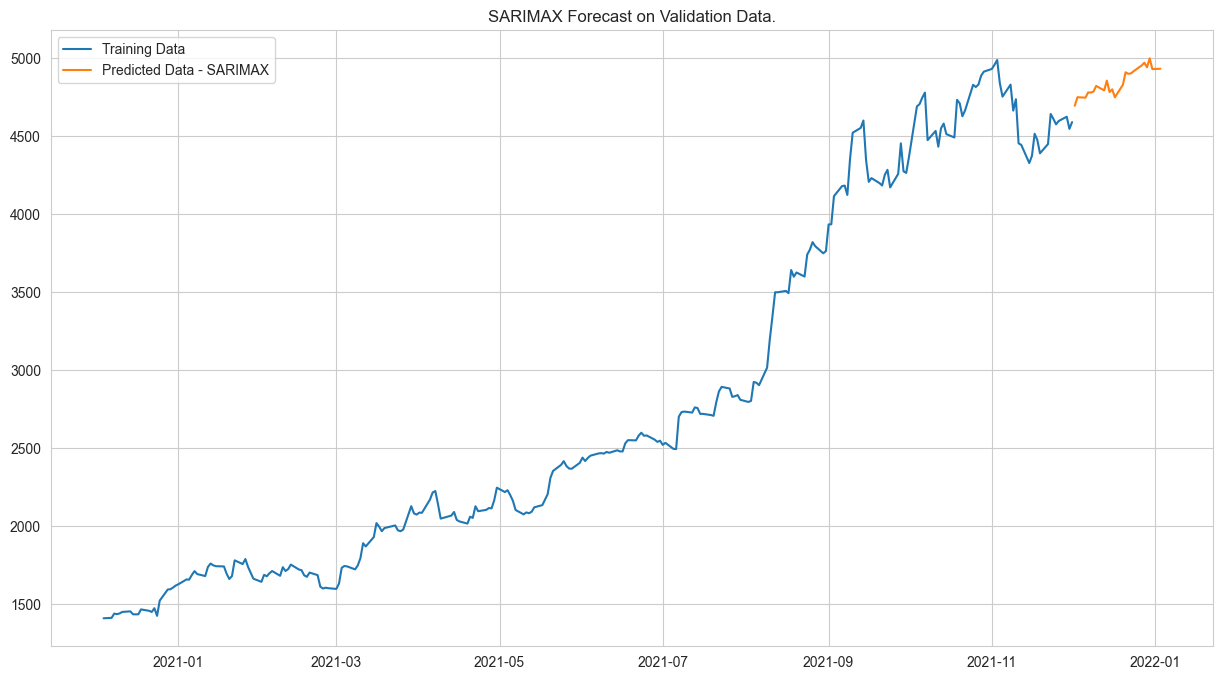

In [30]:
plt.figure(figsize=(15, 8))
plt.plot(stock_data,label='Training Data')
plt.plot(sarimax_forecast,label='Predicted Data - SARIMAX')
plt.legend(loc='best')
plt.title('SARIMAX Forecast on Validation Data.')
plt.minorticks_on()
plt.show()

In [31]:
submission_dataframe = pd.DataFrame({
    'Date': sarimax_forecast.index,
    'Closing': sarimax_forecast.values
})
submission_dataframe.sort_values(by="Date", inplace=True)

In [ ]:
submission_dataframe_file = ('../d. Output Files/MindtreeStockPrice/MindtreeStockPrice_Prediction.csv')
print(f"File name: {submission_dataframe_file.split('/')[3]}")
submission_dataframe.to_csv(submission_dataframe_file, index=False)

File name: MindtreePriceAnalysis_Prediction.csv
